In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import COLLECTIONS as cln
from IPython.display import clear_output
import html5lib
import datetime as dt
import pickle
from collections import Counter
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def create_hm(X, y, model):    
    
    labels = y.value_counts().index
    
    cm = confusion_matrix(y, model.predict(X), labels=labels)
    #cm = pd.DataFrame(cm / cm.sum(axis=1, keepdims=True))
    print('Unique Actual Classes:', len(y.unique()))
    print('Unique Predicted Classes:', len(pd.Series(model.predict(X)).unique()))
    print('Total Test Observations:', len(y))
    
    ax, fig = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', square=True, cbar_kws={'label': '# of Observations'})
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_ylabel('Actual Label')    
    ax.set_xlabel('Predicted Label')
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()
    sns.set(font_scale=20.5)

In [2]:
cnx = create_engine('postgresql://%s:%s@localhost:%s/%s' % (cln.username, 
                                                            cln.password, 
                                                            cln.port,
                                                            cln.db_name))

In [3]:
carrier = 'DL'
airport = 'LGA'

In [4]:
cnx.execute('set enable_hashjoin=off;')
# query = """SELECT * FROM 
#                 (SELECT * FROM ontimeperformance
#                  JOIN weatherairportlinks ON weatherairportlinks."IATA" = ontimeperformance."Origin"
#                  WHERE "Carrier" = '%s' AND "Origin" = '%s') AS sub
#            JOIN weather ON weather."Date" = sub."FlightDate" AND
#                            weather."StationID" = sub."StationID" """ % (carrier, airport)

query_dest = """SELECT * FROM 
                (SELECT *, 
                        wal_origin."StationID" as "OriginStationID", 
                        wal_dest."StationID" as "DestStationID" 
                 FROM ontimeperformance
                 JOIN weatherairportlinks wal_origin ON wal_origin."IATA" = ontimeperformance."Origin"
                 JOIN weatherairportlinks wal_dest ON wal_dest."IATA" = ontimeperformance."Dest"
                 WHERE "Carrier" = '%s' AND "Origin" = '%s') AS sub
            JOIN weather as w_dest ON w_dest."Date" = sub."FlightDate" AND 
                            w_dest."StationID" = sub."DestStationID";""" % (carrier, airport)

query_origin = """SELECT * FROM 
                (SELECT *, 
                        wal_origin."StationID" as "OriginStationID", 
                        wal_dest."StationID" as "DestStationID" 
                 FROM ontimeperformance
                 JOIN weatherairportlinks wal_origin ON wal_origin."IATA" = ontimeperformance."Origin"
                 JOIN weatherairportlinks wal_dest ON wal_dest."IATA" = ontimeperformance."Dest"
                 WHERE "Carrier" = '%s' AND "Origin" = '%s') AS sub
            JOIN weather as w_origin ON w_origin."Date" = sub."FlightDate" AND 
                            w_origin."StationID" = sub."OriginStationID";""" % (carrier, airport)



# query

In [5]:
try:
    import pickle
    with open(carrier+'_'+airport+'.pkl', 'rb') as picklefile:
        df = pickle.load(picklefile)
    new_data = False
except:
    df_origin = pd.read_sql_query(query_origin, cnx)
    new_data = True

In [6]:
df_origin.head()

NameError: name 'df_origin' is not defined

In [7]:
df_origin = df_origin.loc[:, ~df_origin.columns.duplicated()]
df_origin.head()

,PerformanceID,File_Name,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginCityName,OriginStateName,Dest,...,FirstDepTime,TotalAddGTime,LongestAddGTime,IATA,StationID,OriginStationID,DestStationID,Date,Obsv_Type,Obsv_Value
0,2010_01_011979016031169712953N968DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N968DL,1169,LGA,New York,New York,FLL,...,NaN,NaN,NaN,LGA,USW00014732,USW00014732,USW00012849,2010-01-01,WT18,1
1,2010_01_011979016031169712953N968DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N968DL,1169,LGA,New York,New York,FLL,...,NaN,NaN,NaN,LGA,USW00014732,USW00014732,USW00012849,2010-01-01,WSF2,103
2,2010_01_011979016031169712953N968DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N968DL,1169,LGA,New York,New York,FLL,...,NaN,NaN,NaN,LGA,USW00014732,USW00014732,USW00012849,2010-01-01,WESD,0
3,2010_01_011979016031169712953N968DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N968DL,1169,LGA,New York,New York,FLL,...,NaN,NaN,NaN,LGA,USW00014732,USW00014732,USW00012849,2010-01-01,WDF5,300
4,2010_01_011979016031169712953N968DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N968DL,1169,LGA,New York,New York,FLL,...,NaN,NaN,NaN,LGA,USW00014732,USW00014732,USW00012849,2010-01-01,WDF2,310


In [8]:
df_origin = df_origin.drop(['Obsv_Type', 'Obsv_Value'], axis=1).sort_values('PerformanceID').drop_duplicates(['PerformanceID']).set_index('PerformanceID').join(df_origin.pivot(index='PerformanceID', columns='Obsv_Type', values='Obsv_Value'))
len(df_origin)

189784

In [9]:
df_dest = pd.read_sql_query(query_dest, cnx)

In [10]:
df_dest.head()

,PerformanceID,File_Name,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginCityName,OriginStateName,Dest,...,IATA,StationID,IATA,StationID,OriginStationID,DestStationID,StationID,Date,Obsv_Type,Obsv_Value
0,2010_01_01197908371039712953N676DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N676DL,1769,LGA,New York,New York,ATL,...,LGA,USW00014732,ATL,USW00013874,USW00014732,USW00013874,USW00013874,2010-01-01,WDF5,320
1,2010_01_011979011401039712953N976DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N976DL,1775,LGA,New York,New York,ATL,...,LGA,USW00014732,ATL,USW00013874,USW00014732,USW00013874,USW00013874,2010-01-01,WDF5,320
2,2010_01_011979014341039712953N905DE,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N905DE,1781,LGA,New York,New York,ATL,...,LGA,USW00014732,ATL,USW00013874,USW00014732,USW00013874,USW00013874,2010-01-01,WDF5,320
3,2010_01_011979015311039712953N970DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N970DL,1783,LGA,New York,New York,ATL,...,LGA,USW00014732,ATL,USW00013874,USW00014732,USW00013874,USW00013874,2010-01-01,WDF5,320
4,2010_01_011979016211039712953N914DE,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N914DE,1785,LGA,New York,New York,ATL,...,LGA,USW00014732,ATL,USW00013874,USW00014732,USW00013874,USW00013874,2010-01-01,WDF5,320


In [11]:
df_dest = df_dest.loc[:, ~df_dest.columns.duplicated()]
df_dest.head()

,PerformanceID,File_Name,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginCityName,OriginStateName,Dest,...,FirstDepTime,TotalAddGTime,LongestAddGTime,IATA,StationID,OriginStationID,DestStationID,Date,Obsv_Type,Obsv_Value
0,2010_01_01197908371039712953N676DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N676DL,1769,LGA,New York,New York,ATL,...,NaN,NaN,NaN,LGA,USW00014732,USW00014732,USW00013874,2010-01-01,WDF5,320
1,2010_01_011979011401039712953N976DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N976DL,1775,LGA,New York,New York,ATL,...,NaN,NaN,NaN,LGA,USW00014732,USW00014732,USW00013874,2010-01-01,WDF5,320
2,2010_01_011979014341039712953N905DE,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N905DE,1781,LGA,New York,New York,ATL,...,NaN,NaN,NaN,LGA,USW00014732,USW00014732,USW00013874,2010-01-01,WDF5,320
3,2010_01_011979015311039712953N970DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N970DL,1783,LGA,New York,New York,ATL,...,NaN,NaN,NaN,LGA,USW00014732,USW00014732,USW00013874,2010-01-01,WDF5,320
4,2010_01_011979016211039712953N914DE,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N914DE,1785,LGA,New York,New York,ATL,...,NaN,NaN,NaN,LGA,USW00014732,USW00014732,USW00013874,2010-01-01,WDF5,320


In [12]:
df_dest = df_dest.drop(['Obsv_Type', 'Obsv_Value'], axis=1).sort_values('PerformanceID').drop_duplicates(['PerformanceID']).set_index('PerformanceID').join(df_dest.pivot(index='PerformanceID', columns='Obsv_Type', values='Obsv_Value'))
len(df_dest)

167152

In [16]:
df = df_dest.join(df_origin, rsuffix='_origin')
remove_cols = []
for col in df.columns:
    match = re.fullmatch(r'^[A-Z]{2}(\d|[A-Z]){2}(\_\D+)?$', col)
    if not match and col.endswith('_origin'):
        remove_cols.append(col)
df.drop(remove_cols, axis=1, inplace=True)
df.head()

,File_Name,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginCityName,OriginStateName,Dest,DestCityName,...,WT08_origin,WT09_origin,WT11_origin,WT13_origin,WT14_origin,WT16_origin,WT17_origin,WT18_origin,WT19_origin,WT22_origin
PerformanceID,,,,,,,,,,,,,,,,,,,,,
2010_01_011979010241320412953N924DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N924DL,1515,LGA,New York,New York,MCO,Orlando,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
2010_01_011979010411072112953N906DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N906DL,1376,LGA,New York,New York,BOS,Boston,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
2010_01_011979010491169712953N971DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N971DL,1583,LGA,New York,New York,FLL,Fort Lauderdale,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
2010_01_011979010551402712953N361NW,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N361NW,2425,LGA,New York,New York,PBI,West Palm Beach/Palm Beach,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
2010_01_011979011401039712953N976DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N976DL,1775,LGA,New York,New York,ATL,Atlanta,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN


In [17]:
df.head()

,File_Name,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginCityName,OriginStateName,Dest,DestCityName,...,WT08_origin,WT09_origin,WT11_origin,WT13_origin,WT14_origin,WT16_origin,WT17_origin,WT18_origin,WT19_origin,WT22_origin
PerformanceID,,,,,,,,,,,,,,,,,,,,,
2010_01_011979010241320412953N924DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N924DL,1515,LGA,New York,New York,MCO,Orlando,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
2010_01_011979010411072112953N906DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N906DL,1376,LGA,New York,New York,BOS,Boston,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
2010_01_011979010491169712953N971DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N971DL,1583,LGA,New York,New York,FLL,Fort Lauderdale,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
2010_01_011979010551402712953N361NW,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N361NW,2425,LGA,New York,New York,PBI,West Palm Beach/Palm Beach,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
2010_01_011979011401039712953N976DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N976DL,1775,LGA,New York,New York,ATL,Atlanta,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN


In [18]:
df[~df['WeatherDelay'].isnull()][['DepDelay', 'ArrDelay', 
                                  'CRSArrTime', 'ArrTime', 
                                  'WheelsOn', 'WeatherDelay', 
                                  'LateAircraftDelay', 'CarrierDelay', 
                                  'NASDelay', 'SecurityDelay']].sort_values('ArrDelay', 
                                                                            ascending=False).head()

,DepDelay,ArrDelay,CRSArrTime,ArrTime,WheelsOn,WeatherDelay,LateAircraftDelay,CarrierDelay,NASDelay,SecurityDelay
PerformanceID,,,,,,,,,,
2017_08_071979014451530412953N957AT,1171.0,1165.0,19:20:00,14:45:00,14:41:00,0.0,569.0,596.0,0.0,0.0
2016_03_04197905151072112953N951AT,1165.0,1136.0,10:19:00,05:15:00,05:08:00,0.0,1113.0,23.0,0.0,0.0
2017_06_131979012571143312953N338NW,1067.0,1055.0,19:22:00,12:57:00,12:50:00,0.0,0.0,1055.0,0.0,0.0
2016_07_011979014581402712953N961DL,1023.0,1015.0,22:03:00,14:58:00,14:53:00,339.0,0.0,676.0,0.0,0.0
2014_01_021979014561330312953N980DL,973.0,996.0,22:20:00,14:56:00,14:51:00,973.0,0.0,0.0,23.0,0.0


In [19]:
# Data Cleaning

# Replace NaN values with 0
df.loc[:, ['WeatherDelay', 'LateAircraftDelay', 
           'CarrierDelay', 'NASDelay', 'SecurityDelay']] = df.loc[:, ['WeatherDelay', 'LateAircraftDelay', 
                                                                      'CarrierDelay', 'NASDelay', 'SecurityDelay']].fillna(0)
df.isnull().sum(axis=0).sort_values(ascending=False)

SX32                 167151
SN32                 167150
TOBS                 167145
WT17_origin          167098
WT19                 167081
WT15                 167077
WT17                 167071
WT10                 167047
WT19_origin          167036
WT11_origin          167027
WT22_origin          166937
WT11                 166932
WT22                 166918
WT06                 166863
WT09_origin          166813
WT21                 166415
WT09                 166399
WT04                 166345
WT06_origin          166274
WT07_origin          165866
WT07                 165713
WT04_origin          165553
TotalAddGTime        165456
LongestAddGTime      165456
FirstDepTime         165456
WT14                 163982
WT18                 163937
WT02_origin          162297
WT18_origin          162211
WT02                 162090
                      ...  
FlightDate                0
TaxiIn                    0
Cancelled                 0
Diverted                  0
TMIN_origin         

In [20]:
df[['WeatherDelay', 'LateAircraftDelay', 
    'CarrierDelay', 'NASDelay', 'SecurityDelay']].describe()

,WeatherDelay,LateAircraftDelay,CarrierDelay,NASDelay,SecurityDelay
count,167152.000000,167152.000000,167152.000000,167152.000000,167152.000000
mean,0.547621,5.134088,4.025773,3.530212,0.004942
std,10.433711,23.875908,26.080744,15.544538,0.614539
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,973.000000,1113.000000,1055.000000,979.000000,159.000000


In [21]:
# replace na with 0 for WT** variables
import re

for col in df.columns:
    match = re.fullmatch('^WT\d+\_?(\D+)?$', col)
    if match:
#         print(col)
        df.loc[:, col] = df.loc[:, col].fillna(0)

In [22]:
null_counts = df.isnull().sum(axis=0).sort_values(ascending=False)

In [23]:
remove_cols = []
for key, value in null_counts.iteritems():
    if value > len(df)*0.25:
        print('Remove Feature:', key, '(', int(value), ')')
        remove_cols.append(key)
    elif value > 0:
        print('Remove Data Points:', key, '(', int(value), ')')
df.drop(remove_cols, axis=1, inplace=True)
df.dropna(inplace=True)

Remove Feature: SX32 ( 167151 )
Remove Feature: SN32 ( 167150 )
Remove Feature: TOBS ( 167145 )
Remove Feature: FirstDepTime ( 165456 )
Remove Feature: TotalAddGTime ( 165456 )
Remove Feature: LongestAddGTime ( 165456 )
Remove Feature: PSUN ( 158486 )
Remove Feature: TSUN ( 157381 )
Remove Feature: WESD ( 148797 )
Remove Feature: WESD_origin ( 145735 )
Remove Feature: PGTM_origin ( 129734 )
Remove Feature: FMTM_origin ( 129628 )
Remove Feature: PGTM ( 127907 )
Remove Feature: FMTM ( 127875 )
Remove Feature: TAVG ( 72011 )
Remove Feature: TAVG_origin ( 69562 )
Remove Data Points: SNWD ( 35421 )
Remove Data Points: SNOW ( 18538 )
Remove Data Points: WSF5 ( 1216 )
Remove Data Points: WDF5 ( 1216 )
Remove Data Points: WSF5_origin ( 251 )
Remove Data Points: WDF5_origin ( 251 )
Remove Data Points: PRCP ( 24 )
Remove Data Points: TMAX ( 16 )
Remove Data Points: AWND ( 16 )
Remove Data Points: TMIN ( 15 )
Remove Data Points: WSF2 ( 9 )
Remove Data Points: WDF2 ( 9 )


In [24]:
len(df)

130387

In [25]:
df.describe()

,FlightNum,DepDelay,DepDelayMinutes,DepDel15,ArrDelay,ArrDelayMinutes,ArrDel15,TaxiOut,TaxiIn,CRSElapsedTime,...,WT08_origin,WT09_origin,WT11_origin,WT13_origin,WT14_origin,WT16_origin,WT17_origin,WT18_origin,WT19_origin,WT22_origin
count,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,...,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000
mean,1657.289093,11.444945,14.090653,0.183070,2.359284,14.326329,0.195503,28.972635,7.001718,167.041024,...,0.130021,0.001825,0.000552,0.078888,0.026161,0.132797,0.000307,0.023837,0.000560,0.001058
std,702.208937,45.062989,44.132578,0.386726,48.673033,43.257897,0.396589,14.680671,4.477952,27.444664,...,0.336327,0.042685,0.023493,0.269565,0.159613,0.339356,0.017512,0.152541,0.023655,0.032516
min,19.000000,-33.000000,0.000000,0.000000,-79.000000,0.000000,0.000000,2.000000,1.000000,67.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1147.000000,-5.000000,0.000000,0.000000,-21.000000,0.000000,0.000000,19.000000,4.000000,152.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1765.000000,-2.000000,0.000000,0.000000,-9.000000,0.000000,0.000000,26.000000,6.000000,168.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2131.000000,6.000000,6.000000,0.000000,8.000000,8.000000,0.000000,35.000000,8.000000,188.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7385.000000,1171.000000,1171.000000,1.000000,1165.000000,1165.000000,1.000000,189.000000,186.000000,329.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
df.isnull().sum(axis=0).sort_values(ascending=False)[:5]

WT22_origin       0
NASDelay          0
Cancelled         0
Diverted          0
CRSElapsedTime    0
dtype: int64

In [27]:
df['Year'] = df['FlightDate'].apply(lambda x: x.year)
df['ISO_Weekday'] = df['FlightDate'].apply(lambda x: x.weekday())
df['Day_of_Year'] = df['FlightDate'].apply(lambda x: x.timetuple().tm_yday)
df['ArrHour'] = df['CRSArrTime'].apply(lambda x: x.hour)
df['DepHour'] = df['CRSDepTime'].apply(lambda x: x.hour)
df.head()

,File_Name,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginCityName,OriginStateName,Dest,DestCityName,...,WT16_origin,WT17_origin,WT18_origin,WT19_origin,WT22_origin,Year,ISO_Weekday,Day_of_Year,ArrHour,DepHour
PerformanceID,,,,,,,,,,,,,,,,,,,,,
2010_01_011979010241320412953N924DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N924DL,1515,LGA,New York,New York,MCO,Orlando,...,1.0,0.0,1.0,0.0,0.0,2010,4,1,10,7
2010_01_011979011401039712953N976DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N976DL,1775,LGA,New York,New York,ATL,Atlanta,...,1.0,0.0,1.0,0.0,0.0,2010,4,1,12,9
2010_01_011979011411143312953N1334U,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N1334U,7259,LGA,New York,New York,DTW,Detroit,...,1.0,0.0,1.0,0.0,0.0,2010,4,1,11,9
2010_01_011979012011530412953N316US,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N316US,2423,LGA,New York,New York,TPA,Tampa,...,1.0,0.0,1.0,0.0,0.0,2010,4,1,11,7
2010_01_011979012361324412953N318US,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N318US,2429,LGA,New York,New York,MEM,Memphis,...,1.0,0.0,1.0,0.0,0.0,2010,4,1,12,10


In [28]:
if new_data:
    with open(carrier+'_'+airport+'_new.pkl', 'wb') as picklefile:
        pickle.dump(df, picklefile)

In [29]:
df.to_csv(carrier+'_'+airport+'_new.csv')

In [4]:
df = pd.read_csv(carrier+'_'+airport+'_new.csv')

In [5]:
df.head()

,PerformanceID,File_Name,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginCityName,OriginStateName,Dest,...,WT16_origin,WT17_origin,WT18_origin,WT19_origin,WT22_origin,Year,ISO_Weekday,Day_of_Year,ArrHour,DepHour
0,2010_01_011979010241320412953N924DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N924DL,1515,LGA,New York,New York,MCO,...,1.0,0.0,1.0,0.0,0.0,2010,4,1,10,7
1,2010_01_011979011401039712953N976DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N976DL,1775,LGA,New York,New York,ATL,...,1.0,0.0,1.0,0.0,0.0,2010,4,1,12,9
2,2010_01_011979011411143312953N1334U,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N1334U,7259,LGA,New York,New York,DTW,...,1.0,0.0,1.0,0.0,0.0,2010,4,1,11,9
3,2010_01_011979012011530412953N316US,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N316US,2423,LGA,New York,New York,TPA,...,1.0,0.0,1.0,0.0,0.0,2010,4,1,11,7
4,2010_01_011979012361324412953N318US,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N318US,2429,LGA,New York,New York,MEM,...,1.0,0.0,1.0,0.0,0.0,2010,4,1,12,10


In [6]:
x = df.groupby(['Dest', 'FlightDate'], as_index=False)
x = x.mean()
x.head()

,Dest,FlightDate,FlightNum,DepDelay,DepDelayMinutes,DepDel15,ArrDelay,ArrDelayMinutes,ArrDel15,TaxiOut,...,WT16_origin,WT17_origin,WT18_origin,WT19_origin,WT22_origin,Year,ISO_Weekday,Day_of_Year,ArrHour,DepHour
0,ATL,2010-01-01,1783.727273,-3.363636,0.090909,0.000000,-21.454545,0.909091,0.000000,19.363636,...,1.0,0.0,1.0,0.0,0.0,2010.0,4.0,1.0,15.454545,13.363636
1,ATL,2010-01-02,1783.181818,-1.454545,1.818182,0.090909,-18.454545,1.272727,0.000000,33.454545,...,1.0,0.0,1.0,0.0,0.0,2010.0,5.0,2.0,15.181818,13.090909
2,ATL,2010-01-03,1690.600000,17.133333,17.333333,0.400000,-5.866667,6.266667,0.066667,26.000000,...,1.0,0.0,1.0,0.0,0.0,2010.0,6.0,3.0,15.800000,13.733333
3,ATL,2010-01-04,1690.600000,4.866667,7.400000,0.066667,-15.400000,2.533333,0.066667,33.933333,...,0.0,0.0,0.0,0.0,0.0,2010.0,0.0,4.0,15.800000,13.733333
4,ATL,2010-01-05,1563.533333,-3.733333,0.600000,0.000000,-29.066667,0.000000,0.000000,29.866667,...,0.0,0.0,0.0,0.0,0.0,2010.0,1.0,5.0,15.266667,13.266667


/home/chrisgiler/anaconda3/lib/python3.5/site-packages/pandas/plotting/_core.py:178: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


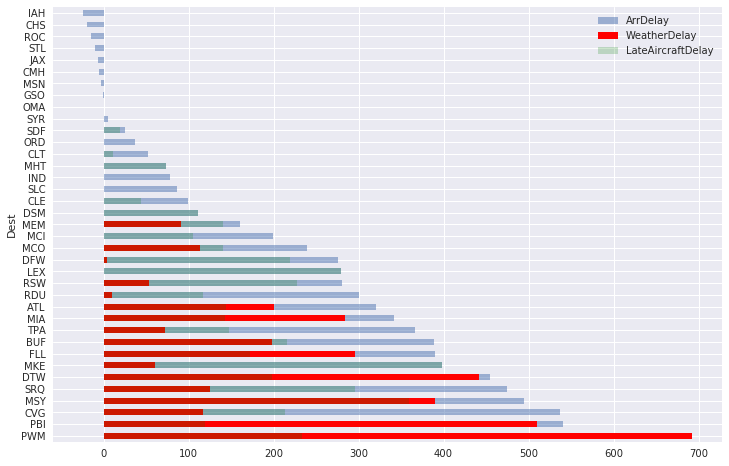

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
x.groupby('Dest', as_index=False).max().sort_values('ArrDelay', ascending=False).plot(x='Dest', y='ArrDelay', kind='barh', ax=ax, alpha=0.5);
x.groupby('Dest', as_index=False).max().sort_values('ArrDelay', ascending=False).plot(x='Dest', y='WeatherDelay', kind='barh', ax=ax, colors='r');
x.groupby('Dest', as_index=False).max().sort_values('ArrDelay', ascending=False).plot(x='Dest', y='LateAircraftDelay', kind='barh', ax=ax, colors='g', alpha=0.2);

In [8]:
df.describe()

,FlightNum,DepDelay,DepDelayMinutes,DepDel15,ArrDelay,ArrDelayMinutes,ArrDel15,TaxiOut,TaxiIn,CRSElapsedTime,...,WT16_origin,WT17_origin,WT18_origin,WT19_origin,WT22_origin,Year,ISO_Weekday,Day_of_Year,ArrHour,DepHour
count,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,...,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000,130387.000000
mean,1657.289093,11.444945,14.090653,0.183070,2.359284,14.326329,0.195503,28.972635,7.001718,167.041024,...,0.132797,0.000307,0.023837,0.000560,0.001058,2013.774203,2.911103,182.502634,15.315423,12.754684
std,702.208937,45.062989,44.132578,0.386726,48.673033,43.257897,0.396589,14.680671,4.477952,27.444664,...,0.339356,0.017512,0.152541,0.023655,0.032516,2.204849,1.992667,103.425518,4.450638,4.332319
min,19.000000,-33.000000,0.000000,0.000000,-79.000000,0.000000,0.000000,2.000000,1.000000,67.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,1.000000,0.000000,5.000000
25%,1147.000000,-5.000000,0.000000,0.000000,-21.000000,0.000000,0.000000,19.000000,4.000000,152.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,1.000000,95.000000,12.000000,9.000000
50%,1765.000000,-2.000000,0.000000,0.000000,-9.000000,0.000000,0.000000,26.000000,6.000000,168.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,3.000000,181.000000,15.000000,12.000000
75%,2131.000000,6.000000,6.000000,0.000000,8.000000,8.000000,0.000000,35.000000,8.000000,188.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000,5.000000,271.000000,19.000000,17.000000
max,7385.000000,1171.000000,1171.000000,1.000000,1165.000000,1165.000000,1.000000,189.000000,186.000000,329.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2017.000000,6.000000,366.000000,23.000000,22.000000


In [9]:
df = df.join(pd.get_dummies(df['Dest'], prefix='Dest', drop_first=True))

In [10]:
df.head()

,PerformanceID,File_Name,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginCityName,OriginStateName,Dest,...,Dest_PWM,Dest_RDU,Dest_ROC,Dest_RSW,Dest_SDF,Dest_SLC,Dest_SRQ,Dest_STL,Dest_SYR,Dest_TPA
0,2010_01_011979010241320412953N924DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N924DL,1515,LGA,New York,New York,MCO,...,0,0,0,0,0,0,0,0,0,0
1,2010_01_011979011401039712953N976DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N976DL,1775,LGA,New York,New York,ATL,...,0,0,0,0,0,0,0,0,0,0
2,2010_01_011979011411143312953N1334U,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N1334U,7259,LGA,New York,New York,DTW,...,0,0,0,0,0,0,0,0,0,0
3,2010_01_011979012011530412953N316US,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N316US,2423,LGA,New York,New York,TPA,...,0,0,0,0,0,0,0,0,0,1
4,2010_01_011979012361324412953N318US,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N318US,2429,LGA,New York,New York,MEM,...,0,0,0,0,0,0,0,0,0,0


In [11]:
dest_cols = []
for col in df.columns:
    match = re.fullmatch('^Dest_[A-Z]+$', col)
    if match:
        dest_cols.append(col)
print(dest_cols)

['Dest_BUF', 'Dest_CHS', 'Dest_CLE', 'Dest_CLT', 'Dest_CMH', 'Dest_CVG', 'Dest_DFW', 'Dest_DSM', 'Dest_DTW', 'Dest_FLL', 'Dest_GSO', 'Dest_IAH', 'Dest_IND', 'Dest_JAX', 'Dest_LEX', 'Dest_MCI', 'Dest_MCO', 'Dest_MEM', 'Dest_MHT', 'Dest_MIA', 'Dest_MKE', 'Dest_MSN', 'Dest_MSY', 'Dest_OMA', 'Dest_ORD', 'Dest_PBI', 'Dest_PWM', 'Dest_RDU', 'Dest_ROC', 'Dest_RSW', 'Dest_SDF', 'Dest_SLC', 'Dest_SRQ', 'Dest_STL', 'Dest_SYR', 'Dest_TPA']


In [12]:
origin_weather_cols = []
destination_weather_cols = []
for col in df.columns:
    match = re.fullmatch('^[A-Z]{2}(\d|[A-Z]){2}(\_\D+)?$', col)
    if match and ('IATA' not in col):
        if col.endswith('_origin'):
            origin_weather_cols.append(col)
        else:
            destination_weather_cols.append(col)
print(origin_weather_cols)
print(destination_weather_cols)

['AWND_origin', 'PRCP_origin', 'SNOW_origin', 'SNWD_origin', 'TMAX_origin', 'TMIN_origin', 'WDF2_origin', 'WDF5_origin', 'WSF2_origin', 'WSF5_origin', 'WT01_origin', 'WT02_origin', 'WT03_origin', 'WT04_origin', 'WT05_origin', 'WT06_origin', 'WT07_origin', 'WT08_origin', 'WT09_origin', 'WT11_origin', 'WT13_origin', 'WT14_origin', 'WT16_origin', 'WT17_origin', 'WT18_origin', 'WT19_origin', 'WT22_origin']
['AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WT10', 'WT11', 'WT13', 'WT14', 'WT15', 'WT16', 'WT17', 'WT18', 'WT19', 'WT21', 'WT22']


In [13]:
def delay_category(arrDel):
    if arrDel < 0:
        return "Early"
    elif arrDel < 10:
        return "On Time"
    elif arrDel < 15:
        return "5 ~ 15 Minute Delay"
    elif arrDel < 30:
        return "15 ~ 30 Minute Delay"
    elif arrDel < 60:
        return "30 ~ 60 Minute Delay"
    elif arrDel < 120:
        return "1 ~ 2 Hour Delay"
    elif arrDel < 240:
        return "2 ~ 4 Hour Delay"
    else:
        return "Over 4 Hour Delay"
    
def make_category(arrDel):
    delay = delay_category(arrDel)
    return delay + ' '*(20-len(delay))

In [14]:
def weather_delay_category(weatherDelay):
    if weatherDelay == 0:
        return 0
    else:
        return 1

In [15]:
df['ArrCat'] = df['ArrDelay'].apply(make_category)
df['WeatherDelayCat'] = df['WeatherDelay'].apply(weather_delay_category)

In [16]:
label = df['ArrDel15']
# label = df_exp['ArrCat']
# label = df_exp['WeatherDelayCat']
feature_names = ['CRSElapsedTime', 'Flights', 'Distance', 'AWND', 'Year', 'ISO_Weekday', 
                 'Day_of_Year', 'ArrHour', 'DepHour']
feature_names += dest_cols
feature_names += origin_weather_cols
feature_names += destination_weather_cols
features = df.loc[:,feature_names]
# features.dropna(axis=1, inplace=True)
features.head()

,CRSElapsedTime,Flights,Distance,AWND,Year,ISO_Weekday,Day_of_Year,ArrHour,DepHour,Dest_BUF,...,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22
0,185.0,1.0,950.0,38.0,2010,4,1,10,7,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,182.0,1.0,761.0,67.0,2010,4,1,12,9,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,140.0,1.0,501.0,53.0,2010,4,1,11,9,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,196.0,1.0,1011.0,38.0,2010,4,1,11,7,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,192.0,1.0,963.0,34.0,2010,4,1,12,10,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
features.isnull().sum(axis=0).sort_values(ascending=False)[:5]

WT22        0
Dest_ROC    0
Dest_MHT    0
Dest_MIA    0
Dest_MKE    0
dtype: int64

In [18]:
label.head()

0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: ArrDel15, dtype: float64

In [19]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, accuracy_score, classification_report
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.preprocessing import StandardScaler

/home/chrisgiler/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=4444)
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [31]:
#!pip install kmeans-smote
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(kind = "regular")
# X_smtrain, y_smtrain = smote.fit_sample(X_train, y_train)

# from collections import Counter
# print(Counter(y_train.values))
# print(Counter(y_smtrain))

In [32]:
clf_tests = [['Unbalanced', 'Naive-Bayes', GaussianNB()],
             ['Unbalanced', 'Logistic Regression', LogisticRegression()],
             ['Unbalanced', 'Decision Tree', DecisionTreeClassifier()],
             ['Unbalanced', 'Random Forest', RandomForestClassifier()],
             ['Unbalanced', 'AdaBoost Random Forest', AdaBoostClassifier(base_estimator=RandomForestClassifier())],
             ['Balanced', 'Naive-Bayes', BalancedBaggingClassifier(GaussianNB(), n_estimators=10)],
             ['Balanced', 'Logistic Regression', BalancedBaggingClassifier(LogisticRegression(), n_estimators=10)],
             ['Balanced', 'Decision Tree', BalancedBaggingClassifier(DecisionTreeClassifier(), n_estimators=10)],
             ['Balanced', 'Random Forest', BalancedBaggingClassifier(RandomForestClassifier(), n_estimators=10)],
             ['Balanced', 'AdaBoost Random Forest', BalancedBaggingClassifier(AdaBoostClassifier(base_estimator=RandomForestClassifier()), n_estimators=10)]]
clf_tests = pd.DataFrame(clf_tests, columns=['Classes', 'Algorithm', 'Model'])
new_cols = ['Accuracy_Train', 'Precision_Train', 'Recall_Train',
            'Accuracy_Test', 'Precision_Test', 'Recall_Test']
for col in new_cols:
    clf_tests[col] = np.zeros(len(clf_tests))
clf_tests.head()

,Classes,Algorithm,Model,Accuracy_Train,Precision_Train,Recall_Train,Accuracy_Test,Precision_Test,Recall_Test
0,Unbalanced,Naive-Bayes,GaussianNB(priors=None),0.0,0.0,0.0,0.0,0.0,0.0
1,Unbalanced,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",0.0,0.0,0.0,0.0,0.0,0.0
2,Unbalanced,Decision Tree,"DecisionTreeClassifier(class_weight=None, crit...",0.0,0.0,0.0,0.0,0.0,0.0
3,Unbalanced,Random Forest,"RandomForestClassifier(bootstrap=True, class_w...",0.0,0.0,0.0,0.0,0.0,0.0
4,Unbalanced,AdaBoost Random Forest,"AdaBoostClassifier(algorithm='SAMME.R',\n ...",0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
def test_classifiers(clf_tests, X_train, y_train, X_test, y_test):
    for i in range(len(clf_tests)):
        print("Testing %s (%s)" % (clf_tests['Algorithm'][i], clf_tests['Classes'][i]))
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        clf = clf_tests.Model[i]
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        clf_tests['Accuracy_Train'][i] = accuracy_score(y_train, y_pred_train)
        clf_tests['Precision_Train'][i] = precision_score(y_train, y_pred_train)
        clf_tests['Recall_Train'][i] = recall_score(y_train, y_pred_train)
        clf_tests['Accuracy_Test'][i] = accuracy_score(y_test, y_pred_test)
        clf_tests['Precision_Test'][i] = precision_score(y_test, y_pred_test)
        clf_tests['Recall_Test'][i] = recall_score(y_test, y_pred_test)
        
    return clf_tests

In [36]:
clf_tests = test_classifiers(clf_tests, X_train, y_train, X_test, y_test)

Testing Naive-Bayes (Unbalanced)


/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value i

Testing Logistic Regression (Unbalanced)
Testing Decision Tree (Unbalanced)
Testing Random Forest (Unbalanced)


/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value i

Testing AdaBoost Random Forest (Unbalanced)


/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value i

Testing Naive-Bayes (Balanced)


/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value i

Testing Logistic Regression (Balanced)


/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value i

Testing Decision Tree (Balanced)


/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value i

Testing Random Forest (Balanced)


/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value i

Testing AdaBoost Random Forest (Balanced)


/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value i

In [47]:
clf_tests.loc[5:, ['Algorithm', 'Accuracy_Test', 'Precision_Test', 'Recall_Test']].T

,5,6,7,8,9
Algorithm,Naive-Bayes,Logistic Regression,Decision Tree,Random Forest,AdaBoost Random Forest
Accuracy_Test,0.20293,0.683846,0.794974,0.791446,0.7939
Precision_Test,0.196344,0.336845,0.480568,0.475751,0.478982
Recall_Test,0.992819,0.634548,0.582844,0.639117,0.599556


In [ ]:
# Plot clf_tests.head()
clf_tests.set_index(['Classes', 'Algorithm'])

In [61]:
# Grid Search
from sklearn.model_selection import GridSearchCV

In [49]:
clfs = []
clfs.append(BalancedBaggingClassifier(RandomForestClassifier(n_estimators=50, verbose=0, n_jobs=-1), n_estimators=10))
clfs.append(RandomForestClassifier(n_estimators=50))
clfs.append(DecisionTreeClassifier())
clfs.append(AdaBoostClassifier(base_estimator=RandomForestClassifier()))
clfs.append(LogisticRegression())
clfs.append(GaussianNB())
# clf = RandomForestClassifier(n_estimators=50)
# clf = DecisionTreeClassifier()
clf = BalancedBaggingClassifier(RandomForestClassifier(n_estimators=50, verbose=0, n_jobs=-1), n_estimators=10)
# clf = LinearSVC()
# clf = AdaBoostClassifier(base_estimator=RandomForestClassifier())
# clf = SVC()
# clf = LogisticRegression()
# clf = GaussianNB()

In [50]:
clf.fit(X_train, y_train)
# clf.fit(X_smtrain, y_smtrain)

y_pred = clf.predict(X_test)

Unique Actual Classes: 2
Unique Predicted Classes: 2
Total Test Observations: 39117


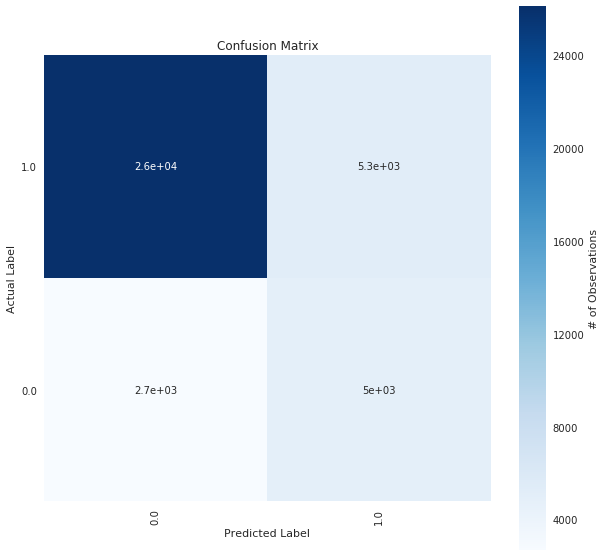

In [51]:
create_hm(X_test,y_test, clf)

In [53]:
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print('')
print(classification_report(y_test, y_pred))

Precision: 0.4820095044127631
Recall: 0.648909779344562
Accuracy: 0.7947184088759363

             precision    recall  f1-score   support

        0.0       0.91      0.83      0.87     31458
        1.0       0.48      0.65      0.55      7659

avg / total       0.82      0.79      0.81     39117



In [54]:
confusion_matrix(y_test, y_pred)

array([[26117,  5341],
       [ 2689,  4970]])

In [31]:
clf.estimators_[0].named_steps

{'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
             oob_score=False, random_state=82828686, verbose=0,
             warm_start=False),
 'sampler': RandomUnderSampler(random_state=540005239, ratio='auto', replacement=False,
           return_indices=False)}

In [32]:
clf_info = clf.estimators_[0].named_steps['classifier']

In [33]:
clf_info.n_features_

102

In [34]:
feature_importance = clf.estimators_[0].named_steps['classifier'].feature_importances_

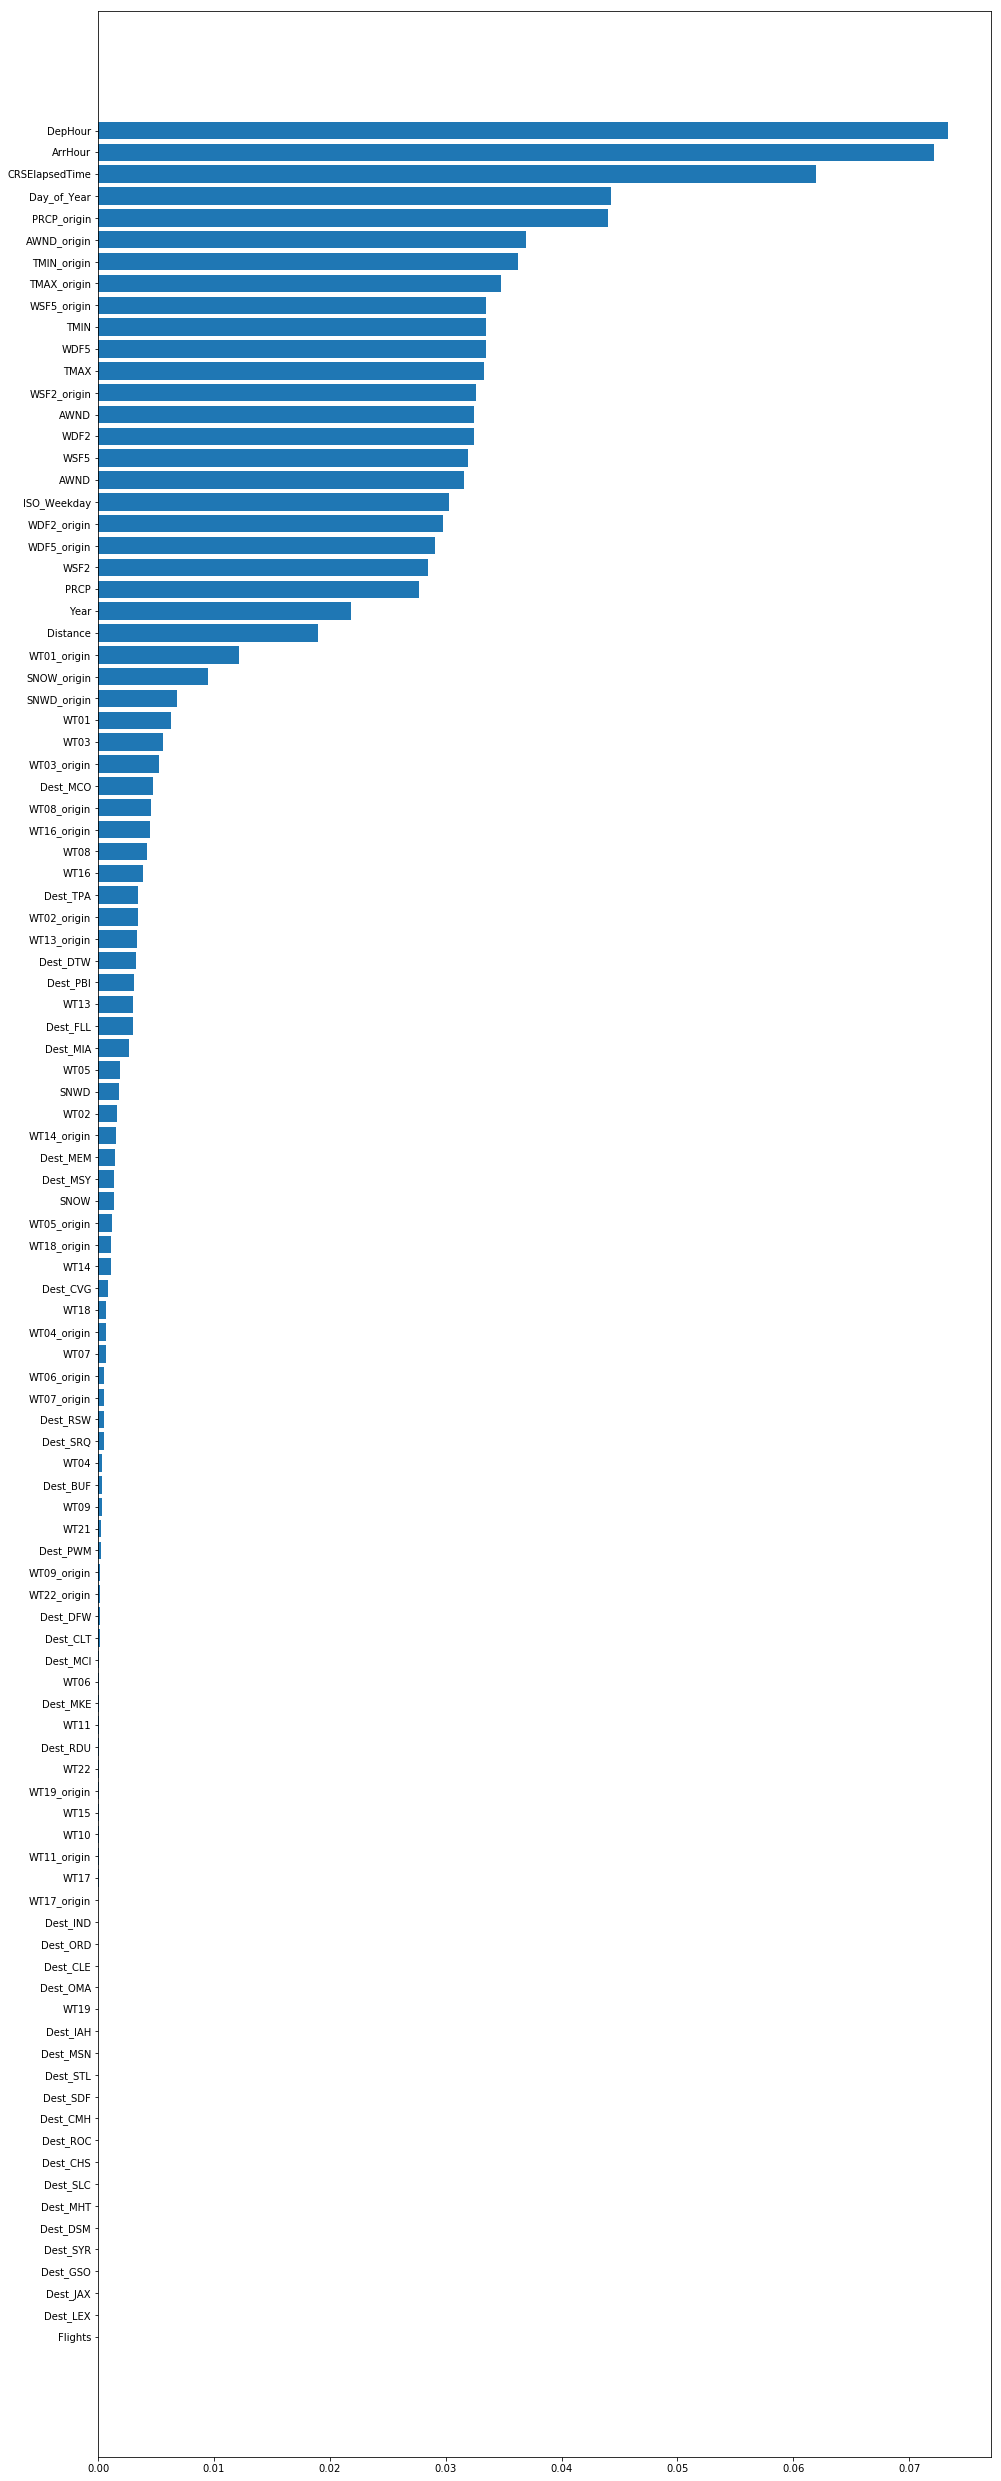

In [46]:
plt.figure(figsize=(16,45))
# plt.barh(np.arange(len(features.columns)), clf.feature_importances_)
# plt.yticks(np.arange(len(features.columns)), features.columns);
idx = np.argsort(feature_importance)
plt.barh(np.arange(len(features.columns)), feature_importance[idx])
plt.yticks(np.arange(len(features.columns)), features.columns[idx]);

In [48]:
new_features = features[features.columns[idx][::-1][:26]]
new_features.head()

NameError: name 'idx' is not defined

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=4444)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
clf = BalancedBaggingClassifier(RandomForestClassifier(n_estimators=50, verbose=0, n_jobs=-1), n_estimators=10)
clf.fit(X_train, y_train)
# clf.fit(X_smtrain, y_smtrain)
y_pred = clf.predict(X_test)

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print('')
print(classification_report(y_test, y_pred))

Precision: 0.48332358104154477
Recall: 0.6470818644731688
Accuracy: 0.7954597745225861

             precision    recall  f1-score   support

        0.0       0.91      0.83      0.87     31458
        1.0       0.48      0.65      0.55      7659

avg / total       0.82      0.80      0.81     39117



In [55]:
new_features.columns

Index(['DepHour', 'ArrHour', 'CRSElapsedTime', 'Day_of_Year', 'PRCP_origin',
       'AWND_origin', 'TMIN_origin', 'TMAX_origin', 'WSF5_origin', 'TMIN',
       'WDF5', 'TMAX', 'WSF2_origin', 'AWND', 'AWND', 'WDF2', 'WSF5', 'AWND',
       'AWND', 'ISO_Weekday', 'WDF2_origin', 'WDF5_origin', 'WSF2', 'PRCP',
       'Year', 'Distance', 'WT01_origin', 'SNOW_origin'],
      dtype='object')

In [58]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

In [59]:
skf = KFold(7, shuffle=True)

In [60]:
scores = []
i = 1
for train_index, test_index in skf.split(features, label):
    print(i)
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index]
    
    clf = BalancedBaggingClassifier(RandomForestClassifier(n_estimators=10, verbose=0, n_jobs=-1), n_estimators=10)
    clf.fit(X_train, y_train)
    
    accuracy = [accuracy_score(y_train, clf.predict(X_train)),
                accuracy_score(y_test, clf.predict(X_test))]
    recall = [recall_score(y_train, clf.predict(X_train)),
                recall_score(y_test, clf.predict(X_test))]
    precision = [precision_score(y_train, clf.predict(X_train)),
                precision_score(y_test, clf.predict(X_test))]
    scores.append((accuracy, recall, precision))
    i += 1

1
2
3
4
5
6
7


In [66]:
np.mean([score[0][1] for score in scores])

0.7962296701787841

In [147]:
scores = cross_val_score(clf, features, label, scoring='recall', n_jobs=-1, verbose=2, )

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   4.4s
[CV] ................................................. , total=   4.4s
[CV] ................................................. , total=   4.3s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished


In [148]:
scores

array([0.51759445, 0.42038366, 0.16582323])

In [149]:
# Grid Search
from sklearn.model_selection import GridSearchCV

In [240]:
parameters = {'n_estimators': [2, 5, 10, 40],
              'min_samples_split': [2, 3, 4, 5, 10],
              'max_features': ['sqrt', 'log2', None]}

In [241]:
clf = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid=parameters, verbose=2, n_jobs=-1)

In [242]:
clf.fit(X_smtrain, y_smtrain)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] min_samples_split=2, max_features=sqrt, n_estimators=2 ..........
[CV] min_samples_split=2, max_features=sqrt, n_estimators=2 ..........
[CV] min_samples_split=2, max_features=sqrt, n_estimators=2 ..........
[CV] min_samples_split=2, max_features=sqrt, n_estimators=5 ..........
[CV] min_samples_split=2, max_features=sqrt, n_estimators=5 ..........
[CV]  min_samples_split=2, max_features=sqrt, n_estimators=2, total=   0.5s
[CV] min_samples_split=2, max_features=sqrt, n_estimators=5 ..........
[CV]  min_samples_split=2, max_features=sqrt, n_estimators=2, total=   0.5s
[CV] min_samples_split=2, max_features=sqrt, n_estimators=10 .........
[CV] min_samples_split=2, max_features=sqrt, n_estimators=10 .........
[CV]  min_samples_split=2, max_features=sqrt, n_estimators=2, total=   0.7s
[CV] min_samples_split=2, max_features=sqrt, n_estimators=10 .........
[CV]  min_samples_split=2, max_features=sqrt, n_estimators=5, total=   

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.1s


[CV] min_samples_split=3, max_features=sqrt, n_estimators=5 ..........
[CV]  min_samples_split=3, max_features=sqrt, n_estimators=2, total=   2.4s
[CV] min_samples_split=3, max_features=sqrt, n_estimators=5 ..........
[CV]  min_samples_split=3, max_features=sqrt, n_estimators=2, total=   2.4s
[CV] min_samples_split=3, max_features=sqrt, n_estimators=10 .........
[CV]  min_samples_split=3, max_features=sqrt, n_estimators=2, total=   2.3s
[CV] min_samples_split=3, max_features=sqrt, n_estimators=10 .........
[CV] min_samples_split=3, max_features=sqrt, n_estimators=10 .........
[CV] min_samples_split=3, max_features=sqrt, n_estimators=40 .........
[CV] min_samples_split=3, max_features=sqrt, n_estimators=40 .........
[CV]  min_samples_split=3, max_features=sqrt, n_estimators=5, total=   2.7s
[CV]  min_samples_split=3, max_features=sqrt, n_estimators=5, total=   2.2s
[CV] min_samples_split=3, max_features=sqrt, n_estimators=40 .........
[CV]  min_samples_split=2, max_features=sqrt, n_esti

[CV]  min_samples_split=10, max_features=sqrt, n_estimators=40, total=   5.2s
[CV]  min_samples_split=2, max_features=log2, n_estimators=10, total=   1.6s
[CV] min_samples_split=3, max_features=log2, n_estimators=2 ..........
[CV] min_samples_split=3, max_features=log2, n_estimators=2 ..........
[CV]  min_samples_split=2, max_features=log2, n_estimators=10, total=   1.9s
[CV] min_samples_split=3, max_features=log2, n_estimators=2 ..........
[CV]  min_samples_split=2, max_features=log2, n_estimators=10, total=   2.0s
[CV] min_samples_split=3, max_features=log2, n_estimators=5 ..........
[CV] min_samples_split=3, max_features=log2, n_estimators=5 ..........
[CV]  min_samples_split=3, max_features=log2, n_estimators=2, total=   1.9s
[CV] min_samples_split=3, max_features=log2, n_estimators=5 ..........
[CV] min_samples_split=3, max_features=log2, n_estimators=10 .........
[CV]  min_samples_split=3, max_features=log2, n_estimators=2, total=   1.7s
[CV] min_samples_split=3, max_features=log

[CV]  min_samples_split=10, max_features=log2, n_estimators=40, total=   3.9s
[CV] min_samples_split=2, max_features=None, n_estimators=40 .........
[CV] min_samples_split=2, max_features=None, n_estimators=40 .........
[CV] min_samples_split=2, max_features=None, n_estimators=40 .........
[CV] min_samples_split=3, max_features=None, n_estimators=2 ..........
[CV] min_samples_split=3, max_features=None, n_estimators=2 ..........
[CV] min_samples_split=3, max_features=None, n_estimators=2 ..........
[CV] min_samples_split=3, max_features=None, n_estimators=5 ..........
[CV]  min_samples_split=2, max_features=None, n_estimators=2, total=  10.9s
[CV] min_samples_split=3, max_features=None, n_estimators=5 ..........
[CV]  min_samples_split=2, max_features=None, n_estimators=2, total=  11.4s
[CV] min_samples_split=3, max_features=None, n_estimators=5 ..........
[CV]  min_samples_split=2, max_features=None, n_estimators=2, total=  12.9s
[CV] min_samples_split=3, max_features=None, n_estimato

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.3min


[CV]  min_samples_split=3, max_features=None, n_estimators=2, total=  23.4s
[CV] min_samples_split=4, max_features=None, n_estimators=2 ..........
[CV]  min_samples_split=3, max_features=None, n_estimators=2, total=  22.7s
[CV] min_samples_split=4, max_features=None, n_estimators=5 ..........
[CV]  min_samples_split=3, max_features=None, n_estimators=5, total=  26.4s
[CV] min_samples_split=4, max_features=None, n_estimators=5 ..........
[CV]  min_samples_split=3, max_features=None, n_estimators=5, total=  24.7s
[CV] min_samples_split=4, max_features=None, n_estimators=5 ..........
[CV]  min_samples_split=3, max_features=None, n_estimators=5, total=  25.9s
[CV] min_samples_split=4, max_features=None, n_estimators=10 .........
[CV]  min_samples_split=3, max_features=None, n_estimators=10, total=  25.8s
[CV] min_samples_split=4, max_features=None, n_estimators=10 .........
[CV]  min_samples_split=3, max_features=None, n_estimators=10, total=  28.1s
[CV] min_samples_split=4, max_features=N

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [2, 3, 4, 5, 10], 'max_features': ['sqrt', 'log2', None], 'n_estimators': [2, 5, 10, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [243]:
clf.best_params_

{'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 40}

In [244]:
y_pred = clf.predict(X_test)

In [245]:
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print('')
print(classification_report(y_test, y_pred))

Precision: 0.5781154082259055
Recall: 0.4918396657527092
Accuracy: 0.8302272669171972

             precision    recall  f1-score   support

        0.0       0.88      0.91      0.90     31458
        1.0       0.58      0.49      0.53      7659

avg / total       0.82      0.83      0.82     39117



In [236]:
confusion_matrix(y_test, y_pred)

array([[30372,  1086],
       [ 4775,  2884]])

In [215]:
features.columns

Index(['CRSElapsedTime', 'Flights', 'Distance', 'AWND', 'Year', 'ISO_Weekday',
       'Day_of_Year', 'ArrHour', 'DepHour', 'DepDelay', 'AWND_origin',
       'PRCP_origin', 'SNOW_origin', 'SNWD_origin', 'TMAX_origin',
       'TMIN_origin', 'WDF2_origin', 'WDF5_origin', 'WSF2_origin',
       'WSF5_origin', 'WT01_origin', 'WT02_origin', 'WT03_origin',
       'WT04_origin', 'WT05_origin', 'WT06_origin', 'WT07_origin',
       'WT08_origin', 'WT09_origin', 'WT11_origin', 'WT13_origin',
       'WT14_origin', 'WT16_origin', 'WT17_origin', 'WT18_origin',
       'WT19_origin', 'WT22_origin', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04',
       'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WT10', 'WT11', 'WT13', 'WT14',
       'WT15', 'WT16', 'WT17', 'WT18', 'WT19', 'WT21', 'WT22'],
      dtype='object')

In [158]:
def get_scores(y_test, y_pred):
    from sklearn.metrics import accuracy_score, recall_score, precision_score
    return ', '.join([str(accuracy_score(y_test, y_pred)),
                      str(recall_score(y_test, y_pred)),
                      str(precision_score(y_test, y_pred))])

def test_classifiers(X, y, scale_values=True):
    from sklearn.cross_validation import train_test_split
    from sklearn.metrics import accuracy_score, recall_score, precision_score
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.learning_curve import learning_curve
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.cross_validation import cross_val_score
    from IPython.display import clear_output
    from sklearn.preprocessing import StandardScaler

    print("Loading Data...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 4444)
    print("Scaling Data...")
    if scale_values:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    score = []
    nn = []
    for i in range(1,10,3):
        clear_output(wait=True)
        print('Training/Testing KNN: %d/%d' % (i, 10))
        knn = KNeighborsClassifier(n_neighbors = i)
        knn.fit(X_train, y_train)
        score.append(accuracy_score(y_test, knn.predict(X_test)))
        nn.append(i)

    plt.plot(nn, score)
    plt.title('KNN Accuracy by Nearest Neighbors')
    plt.ylabel('Accuracy')
    plt.xlabel('Nearest Neighbors');
    print('Best KNN Accuracy: ' + str(max(score)))
    print('Best NN value: ' + str(nn[score.index(max(score))]))

    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    lr_score = (get_scores(y_test, lr.predict(X_test)))
    print('LogReg Accuracy: ' + str(lr_score))

    nb = GaussianNB()
    nb.fit(X_train, y_train)
    nb_score = (get_scores(y_test, nb.predict(X_test)))
    print('GaussianNB Accuracy: ' + str(nb_score))

#     svc = SVC()
#     svc.fit(X_train, y_train)
#     svc_score = (accuracy_score(y_test, svc.predict(X_test)))
#     print('SVC Accuracy: ' + str(svc_score))

    dtc = DecisionTreeClassifier()
    dtc.fit(X_train, y_train)
    dtc_score = (get_scores(y_test, dtc.predict(X_test)))
    print('Decision Tree Accuracy: ' + str(dtc_score))

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    rf_score = (get_scores(y_test, rf.predict(X_test)))
    print('Random Forest Accuracy: ' + str(rf_score))

#     knn_cv = np.mean(cross_val_score(knn, X, y, ))
#     print('KNN CV Score: ' + str(knn_cv))

    lr_cv = np.mean(cross_val_score(lr, X, y))
    print('LogReg CV Score: ' + str(lr_cv))

    nb_cv = np.mean(cross_val_score(nb, X, y))
    print('GaussianNB CV Score: ' + str(nb_cv))

    svc_cv = np.mean(cross_val_score(svc, X, y))
    print('SVC CV Score: ' + str(svc_cv))

    dtc_cv = np.mean(cross_val_score(dtc, X, y))
    print('Decision Tree CV Score: ' + str(dtc_cv))

    rf_cv = np.mean(cross_val_score(rf, X, y))
    print('Random Forest CV Score: ' + str(rf_cv))

In [159]:
test_classifiers(features, label)

Loading Data...
Scaling Data...
LogReg Accuracy: 0.809552228327, 0.0999024044007, 0.614964500273
GaussianNB Accuracy: 0.770690351231, 0.225623280987, 0.369675824975
Decision Tree Accuracy: 0.77990556599, 0.472362700736, 0.44679422625
Random Forest Accuracy: 0.840269610855, 0.405554076834, 0.655716539951
LogReg CV Score: 0.809165731979
GaussianNB CV Score: 0.756918005508
Decision Tree CV Score: 0.698530302312
Random Forest CV Score: 0.791303981506


In [147]:
# Baseline
y_base = [1]*len(y_pred)
print("Precision:", precision_score(y_test, y_base))
print("Recall:", recall_score(y_test, y_base))
print("Accuracy:", accuracy_score(y_test, y_base))
print(confusion_matrix(y_test, y_base))

Precision: 0.195309894508
Recall: 1.0
Accuracy: 0.195309894508
[[    0 45844]
 [    0 11127]]


In [148]:
# Random Guessing
y_guess = [int(i) for i in (np.random.randn(len(y_pred)) < 0.5)]
print("Precision:", precision_score(y_test, y_guess))
print("Recall:", recall_score(y_test, y_guess))
print("Accuracy:", accuracy_score(y_test, y_guess))
print(confusion_matrix(y_test, y_guess))

Precision: 0.197027633323
Recall: 0.694616698122
Accuracy: 0.387460286813
[[14345 31499]
 [ 3398  7729]]


In [142]:
len(features)

189903